# Testing Regularization on MNIST with LeNet

## Imports and data loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import jupyter_black
from torchsummary import summary

from data_generators import data_loader_MNIST
from model_classes import LeNet
from tools import accuracy, plot_results, plot_reg_results, svb

jupyter_black.load()

C:\Users\aslak\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Loading MNIST dataset
in_channels = 1
train_loader, test_loader = data_loader_MNIST()
summary_model = LeNet(lr=0.01, momentum=0.9, in_channels=in_channels).to(device)
summary(summary_model, (in_channels, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
           Dropout-6                  [-1, 120]               0
            Linear-7                   [-1, 84]          10,164
           Dropout-8                   [-1, 84]               0
            Linear-9                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
---------------------------------------------

## Train function

In [4]:
def train(
    dl,
    model,
    n_epochs=2,
    l1=False,
    l1_lmbd=0.00001,
    l2=False,
    l2_lmbd=0.0001,
    l1_l2=False,
    soft_svb=False,
    soft_svb_lmbd=0.01,
    hard_svb=False,
    hard_svb_lmbd=0.001,
    jacobi_reg=False,
    jacobi_reg_lmbd=0.001,
    jacobi_det_reg=False,
    jacobi_det_reg_lmbd=0.001,
    conf_penalty=False,
    conf_penalty_lmbd=0.1,
    label_smoothing=False,
    label_smoothing_lmbd=0.1,
):
    losses = []
    epochs = []
    weights = []
    accuracies = []
    reg_losses = []

    for epoch in range(n_epochs):
        N = len(dl)
        for param in model.parameters():
            weights.append(param.detach().numpy().copy())
        for i, (data, labels) in enumerate(dl):
            epochs.append(epoch + i / N)
            loss_data, reg_loss_data = model.train_step(
                data,
                labels,
                l1=l1,
                l1_lmbd=l1_lmbd,
                l2=l2,
                l2_lmbd=l2_lmbd,
                l1_l2=l1_l2,
                soft_svb=soft_svb,
                soft_svb_lmbd=soft_svb_lmbd,
                jacobi_reg=jacobi_reg,
                jacobi_reg_lmbd=jacobi_reg_lmbd,
                jacobi_det_reg=jacobi_det_reg,
                jacobi_det_reg_lmbd=jacobi_det_reg_lmbd,
                conf_penalty=conf_penalty,
                conf_penalty_lmbd=conf_penalty_lmbd,
                label_smoothing=label_smoothing,
                label_smoothing_lmbd=label_smoothing_lmbd,
            )
            losses.append(loss_data)
            reg_losses.append(reg_loss_data)

        if hard_svb:
            svb(model, eps=hard_svb_lmbd)

        acc = accuracy(model, test_loader)
        accuracies.append(acc)
        model.counter = 0
        print(f"Epoch: {epoch}")
        print("Accuracy of the network on the test images: %d %%" % (100 * acc))
    return losses, reg_losses, epochs, weights, accuracies

## Hyperparameters

In [5]:
lr = 0.01
momentum = 0.9

## No regularization

In [31]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, accuracies = train(train_loader, model, n_epochs)

Epoch: 0
Accuracy of the network on the test images: 74 %
Epoch: 1
Accuracy of the network on the test images: 84 %
Epoch: 2
Accuracy of the network on the test images: 86 %
Epoch: 3
Accuracy of the network on the test images: 86 %
Epoch: 4
Accuracy of the network on the test images: 93 %


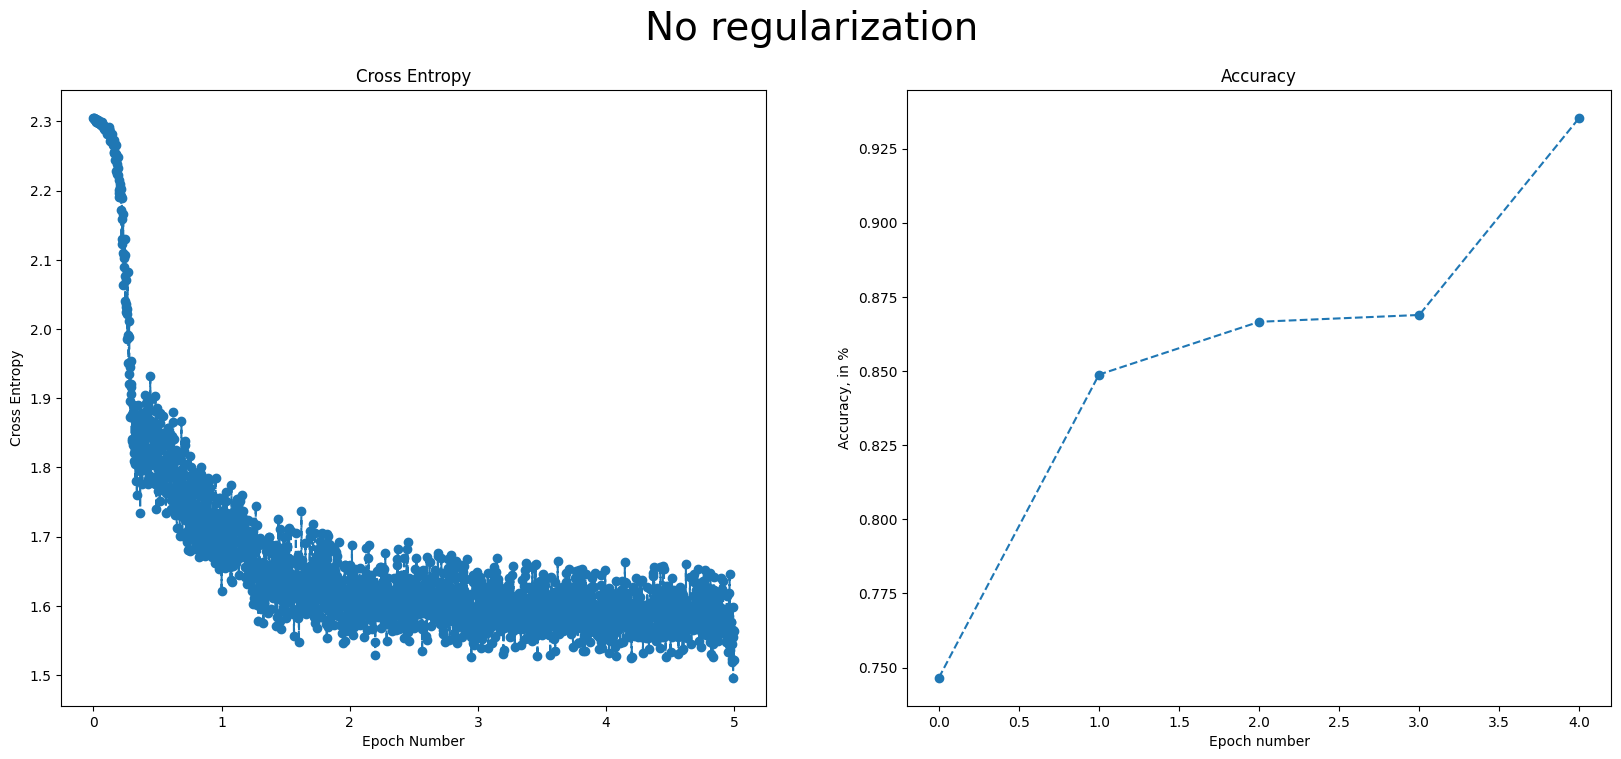

In [32]:
plot_results(epochs, losses, accuracies, title="No regularization")

## L1 Regularization

In [33]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, l1=True, l1_lmbd=0.001
)

Epoch: 0
Accuracy of the network on the test images: 66 %
Epoch: 1
Accuracy of the network on the test images: 71 %
Epoch: 2
Accuracy of the network on the test images: 81 %
Epoch: 3
Accuracy of the network on the test images: 83 %
Epoch: 4
Accuracy of the network on the test images: 83 %


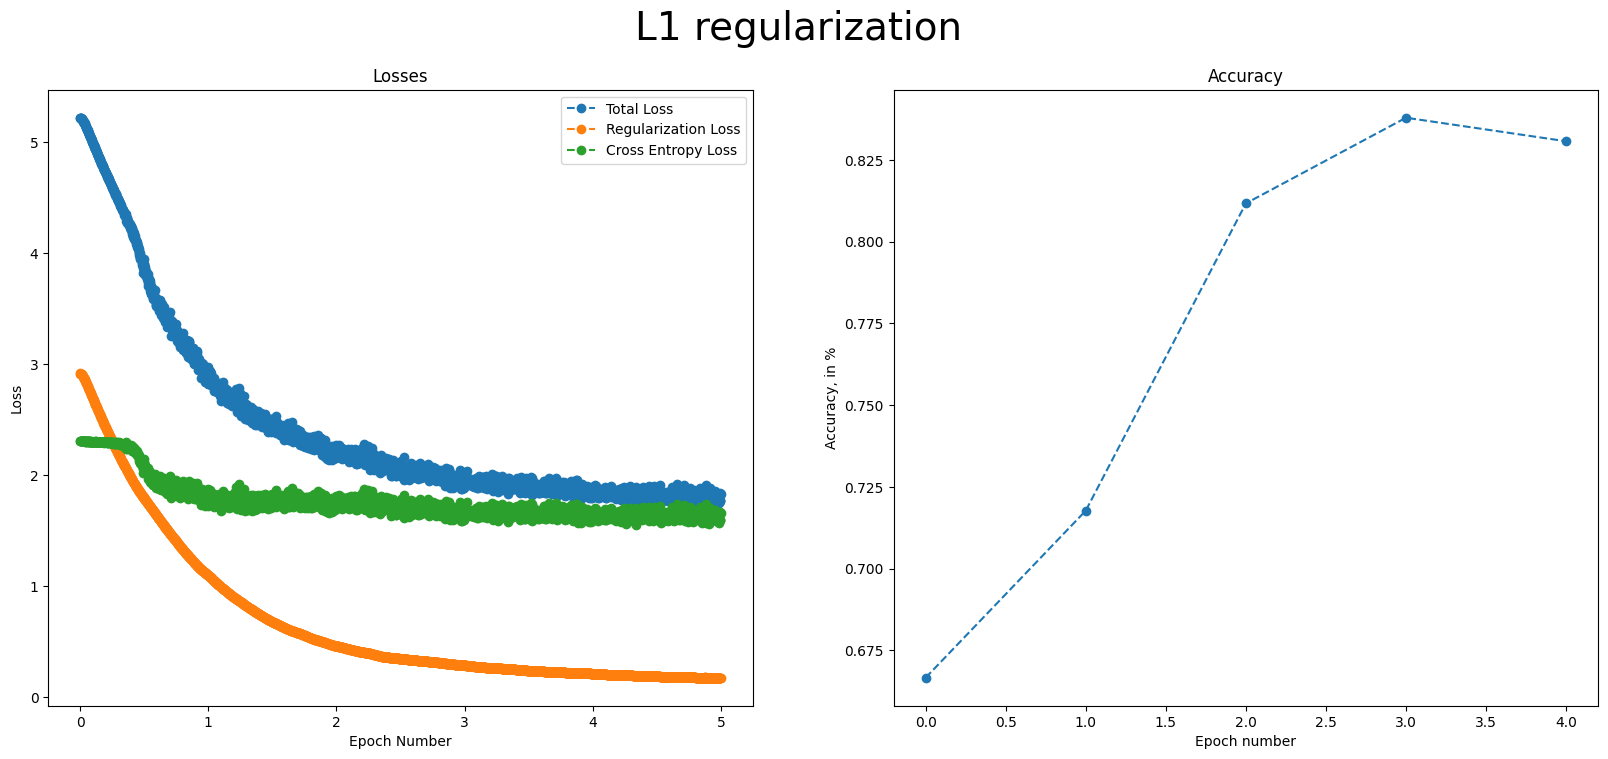

In [34]:
plot_reg_results(epochs, losses, reg_losses, accuracies, title="L1 regularization")

## L2 Regularization

In [35]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, l2=True, l2_lmbd=0.01
)

Epoch: 0
Accuracy of the network on the test images: 74 %
Epoch: 1
Accuracy of the network on the test images: 76 %
Epoch: 2
Accuracy of the network on the test images: 85 %
Epoch: 3
Accuracy of the network on the test images: 87 %
Epoch: 4
Accuracy of the network on the test images: 88 %


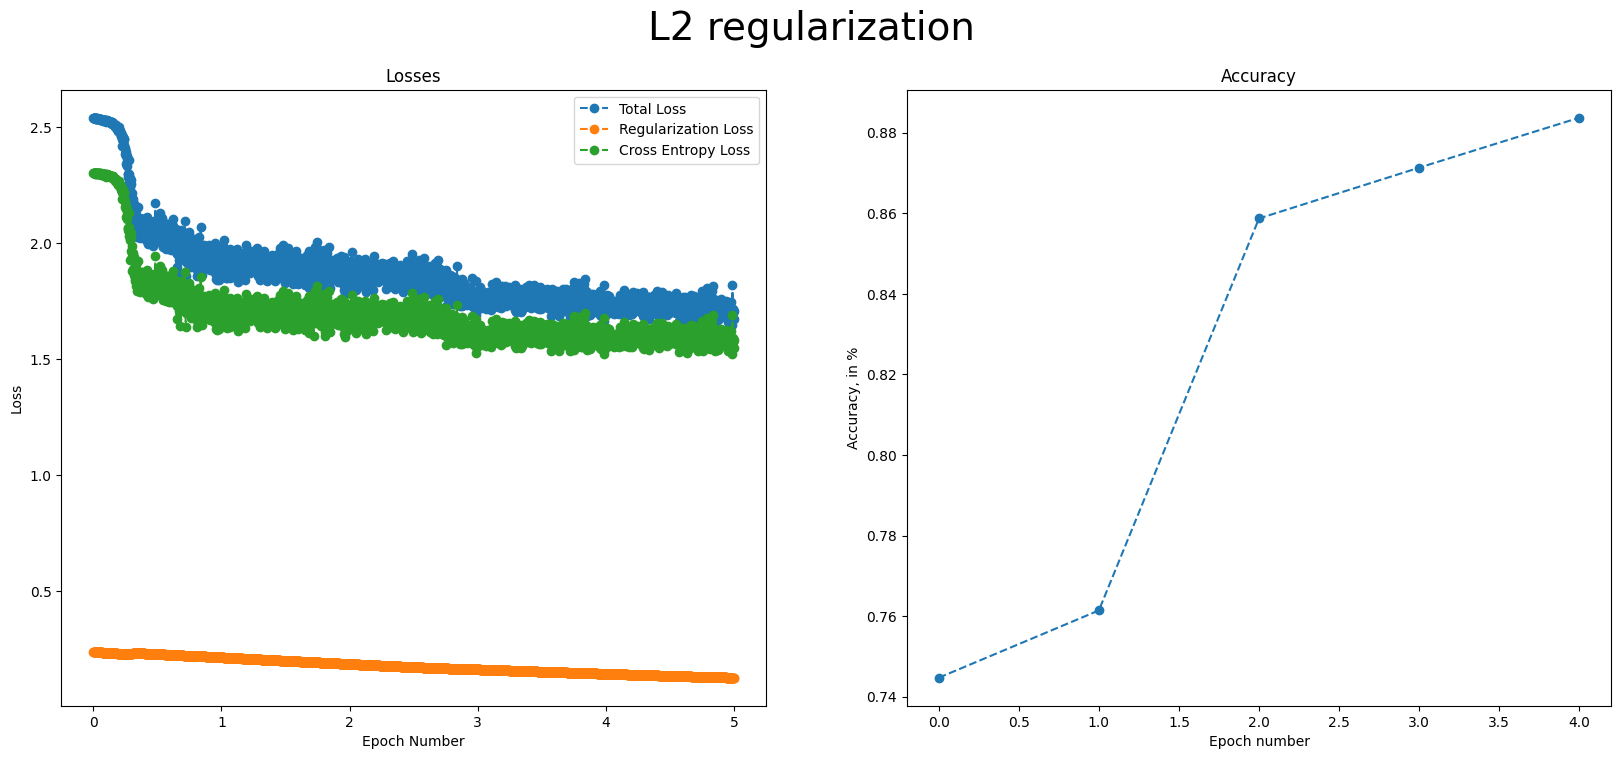

In [36]:
plot_reg_results(epochs, losses, reg_losses, accuracies, title="L2 regularization")

## L1 and L2 Regularization

In [37]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, l1=True, l1_lmbd=0.001, l2=True, l2_lmbd=0.001
)

Epoch: 0
Accuracy of the network on the test images: 84 %
Epoch: 1
Accuracy of the network on the test images: 89 %
Epoch: 2
Accuracy of the network on the test images: 90 %
Epoch: 3
Accuracy of the network on the test images: 92 %
Epoch: 4
Accuracy of the network on the test images: 93 %


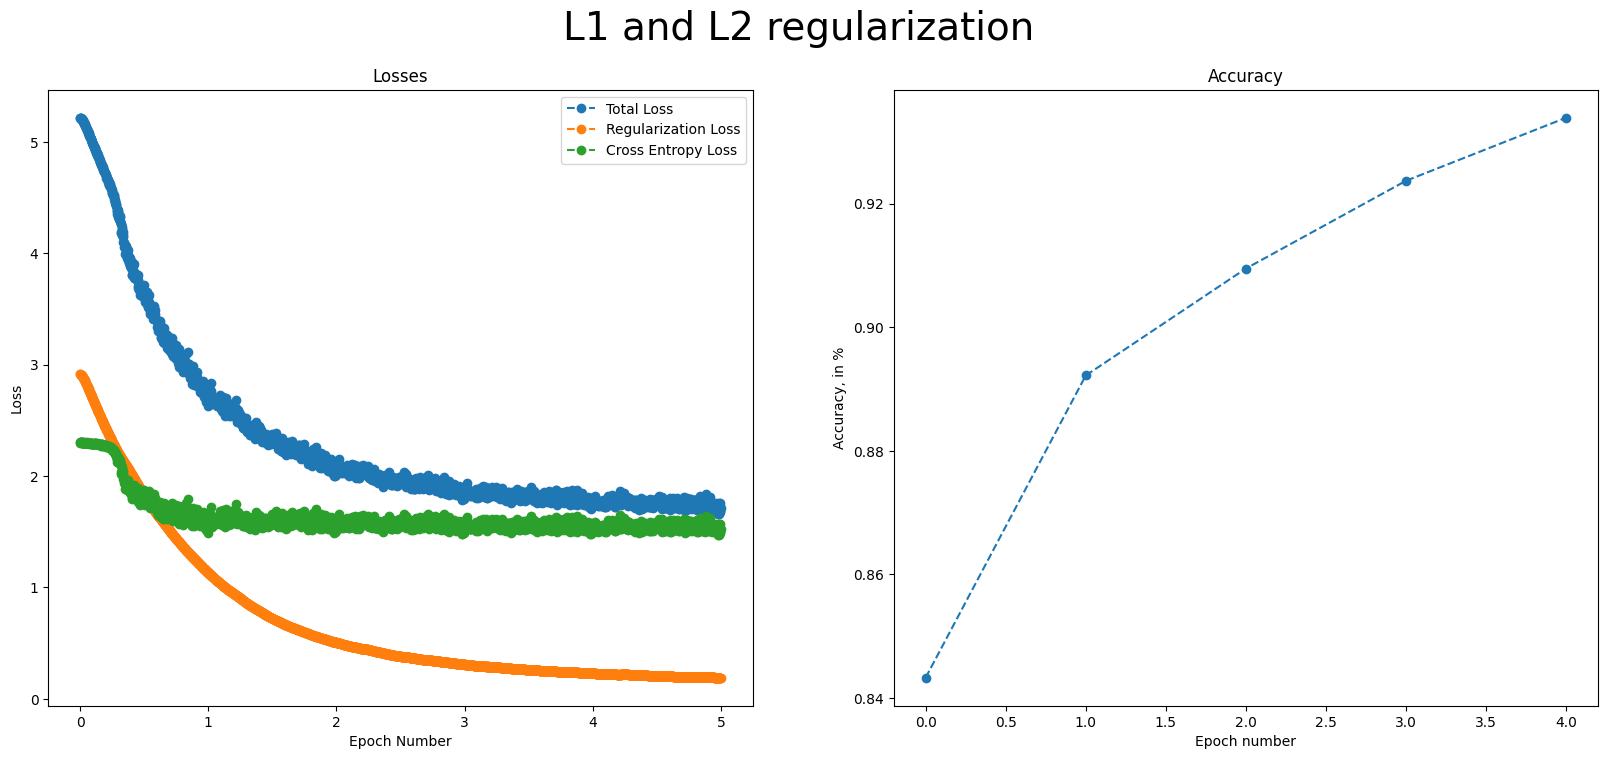

In [38]:
plot_reg_results(
    epochs, losses, reg_losses, accuracies, title="L1 and L2 regularization"
)

## Soft SVB Regularization

In [39]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, soft_svb=True, soft_svb_lmbd=0.01
)
print(len(epochs))

Epoch: 0
Accuracy of the network on the test images: 83 %
Epoch: 1
Accuracy of the network on the test images: 85 %
Epoch: 2
Accuracy of the network on the test images: 87 %
Epoch: 3
Accuracy of the network on the test images: 87 %
Epoch: 4
Accuracy of the network on the test images: 88 %
2345


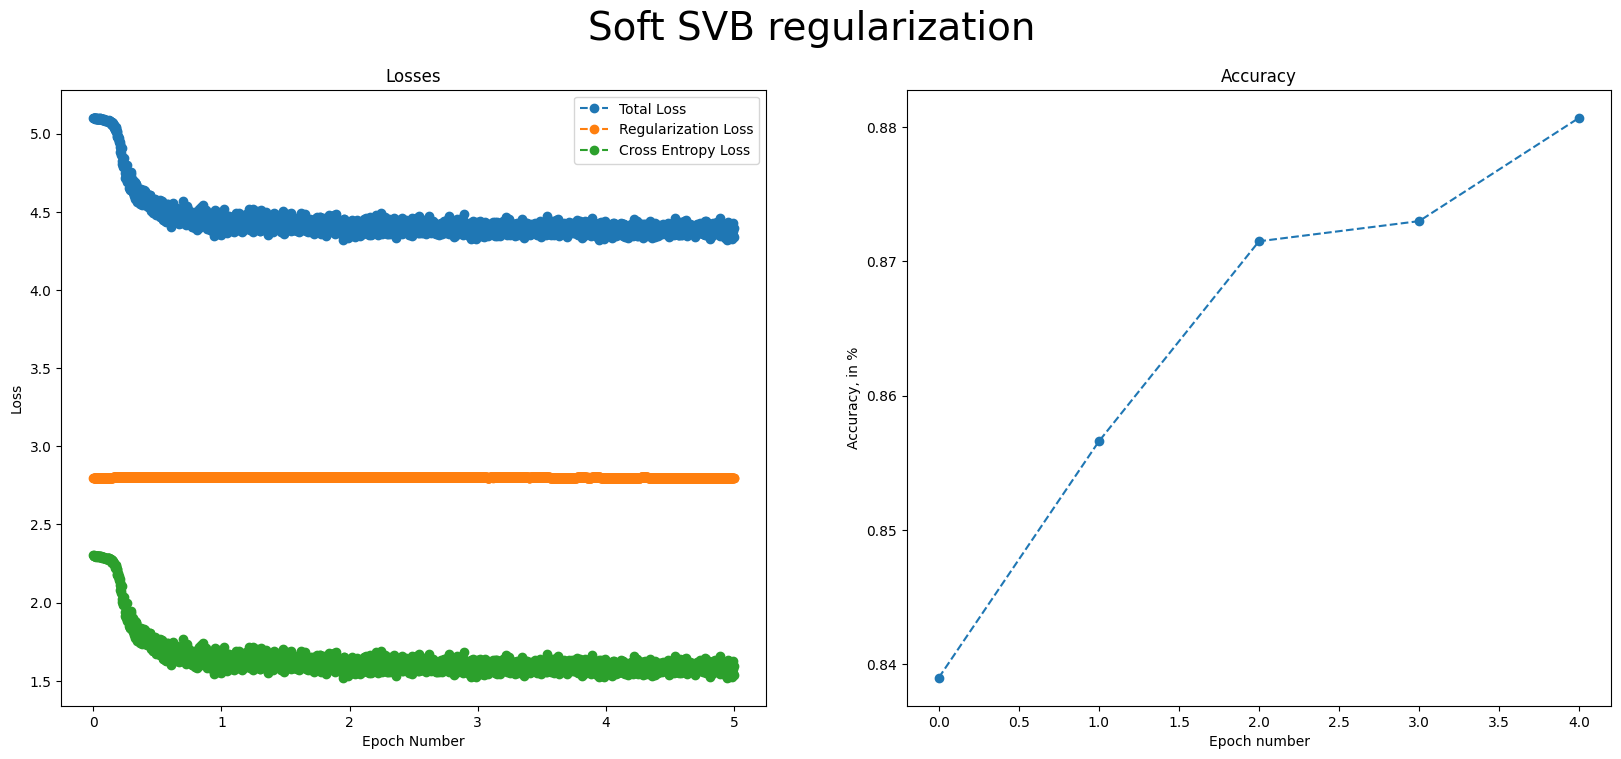

In [40]:
plot_reg_results(
    epochs, losses, reg_losses, accuracies, title="Soft SVB regularization"
)

## Hard SVB Regularization

In [41]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, hard_svb=True, hard_svb_lmbd=0.00001
)

Epoch: 0
Accuracy of the network on the test images: 74 %
Epoch: 1
Accuracy of the network on the test images: 85 %
Epoch: 2
Accuracy of the network on the test images: 86 %
Epoch: 3
Accuracy of the network on the test images: 96 %
Epoch: 4
Accuracy of the network on the test images: 97 %


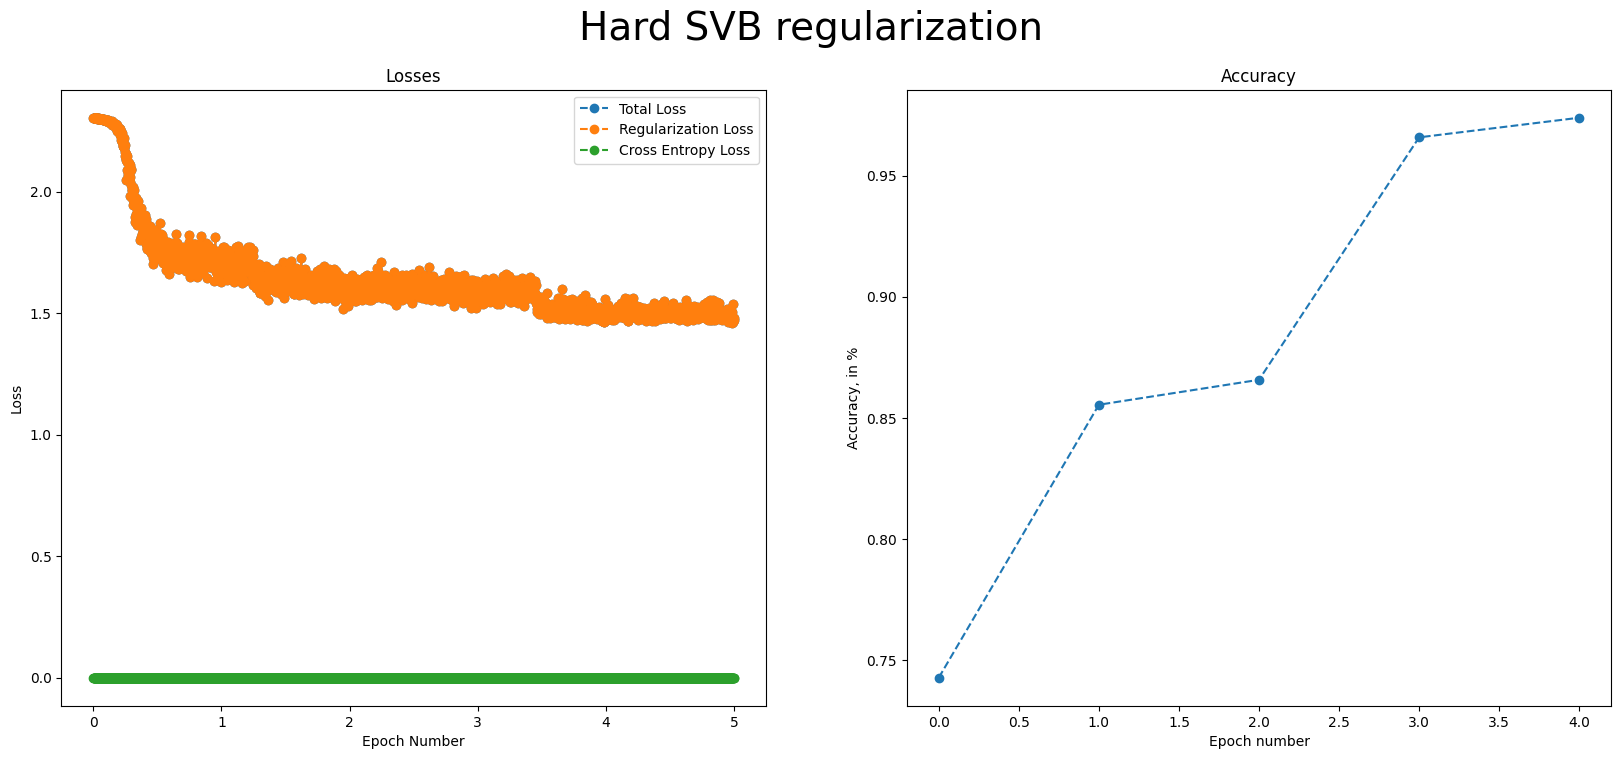

In [42]:
plot_reg_results(
    epochs, losses, reg_losses, accuracies, title="Hard SVB regularization"
)

## Jacobi Regularization

In [43]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 3
losses, reg_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, jacobi_reg=True, jacobi_reg_lmbd=1
)

calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 0
Accuracy of the network on the test images: 83 %
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 1
Accuracy of the network on the test images: 93 %
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 2
Accuracy of the network on the test images: 95 %


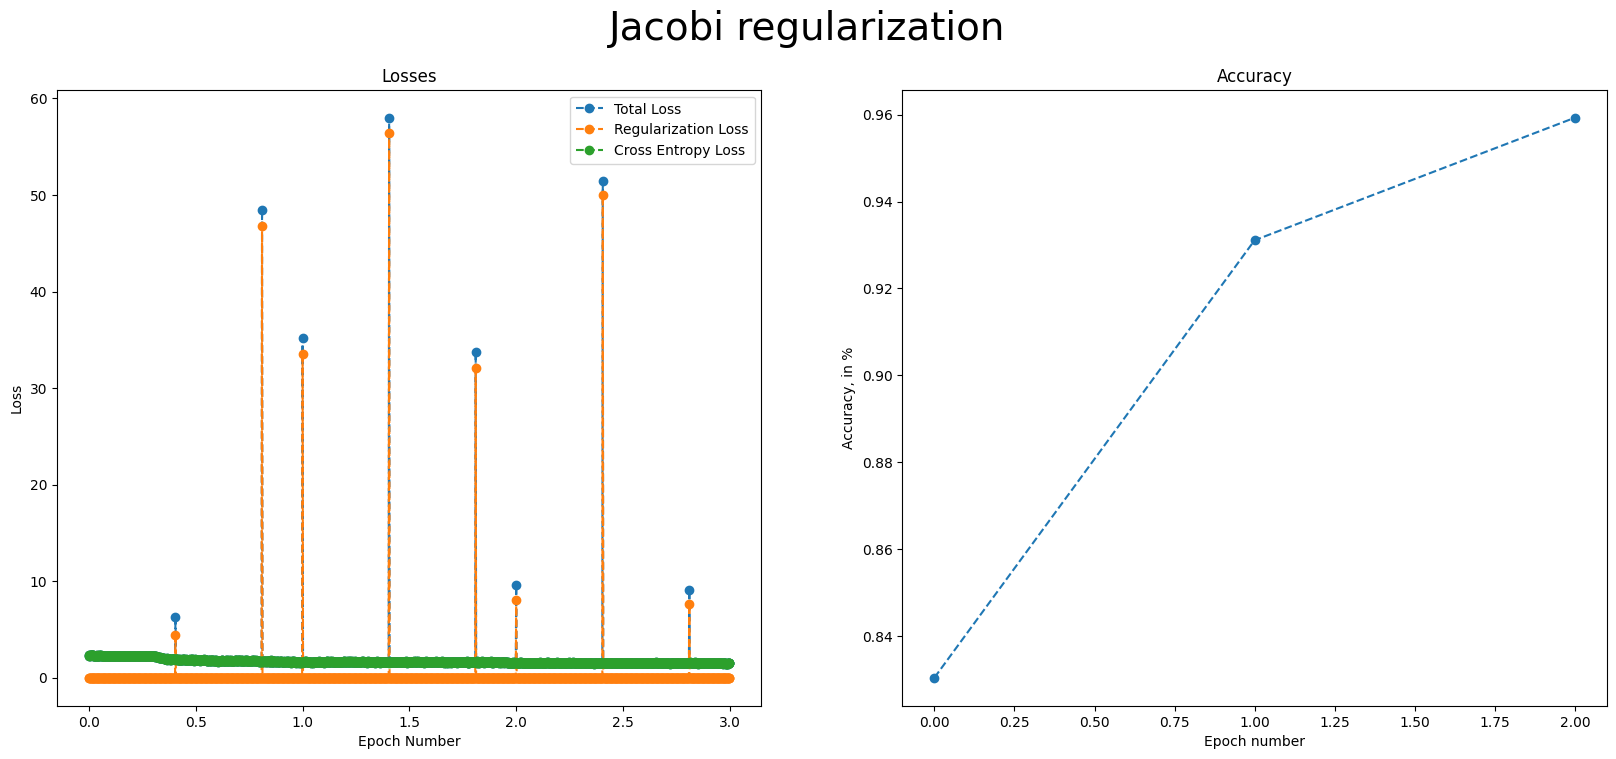

In [44]:
plot_reg_results(epochs, losses, reg_losses, accuracies, title="Jacobi regularization")

## Jacobi Determinant Regularization

In [45]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 3
losses, reg_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, jacobi_det_reg=True, jacobi_det_reg_lmbd=0.001
)

calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 0
Accuracy of the network on the test images: 74 %
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 1
Accuracy of the network on the test images: 76 %
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 2
Accuracy of the network on the test images: 86 %


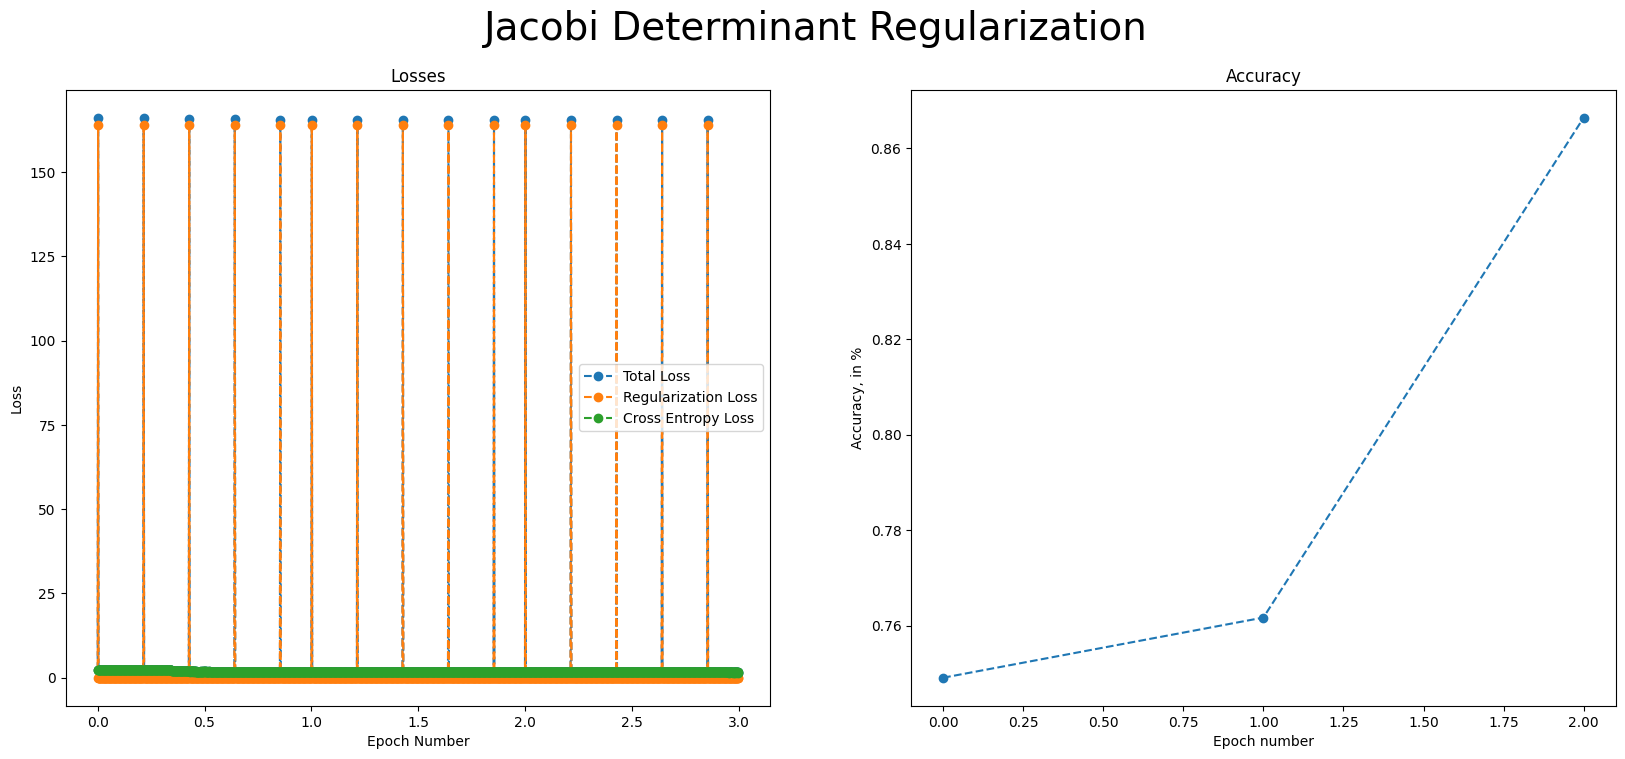

In [46]:
plot_reg_results(
    epochs, losses, reg_losses, accuracies, title="Jacobi Determinant Regularization"
)

## Dropout Regularization

In [8]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels, dropout_rate=0.2).to(
    device
)
n_epochs = 10
losses, reg_losses, epochs, weights, accuracies = train(train_loader, model, n_epochs)

Epoch: 0
Accuracy of the network on the test images: 81 %
Epoch: 1
Accuracy of the network on the test images: 85 %
Epoch: 2
Accuracy of the network on the test images: 86 %
Epoch: 3
Accuracy of the network on the test images: 93 %
Epoch: 4
Accuracy of the network on the test images: 95 %
Epoch: 5
Accuracy of the network on the test images: 96 %
Epoch: 6
Accuracy of the network on the test images: 96 %
Epoch: 7
Accuracy of the network on the test images: 96 %
Epoch: 8
Accuracy of the network on the test images: 97 %
Epoch: 9
Accuracy of the network on the test images: 97 %


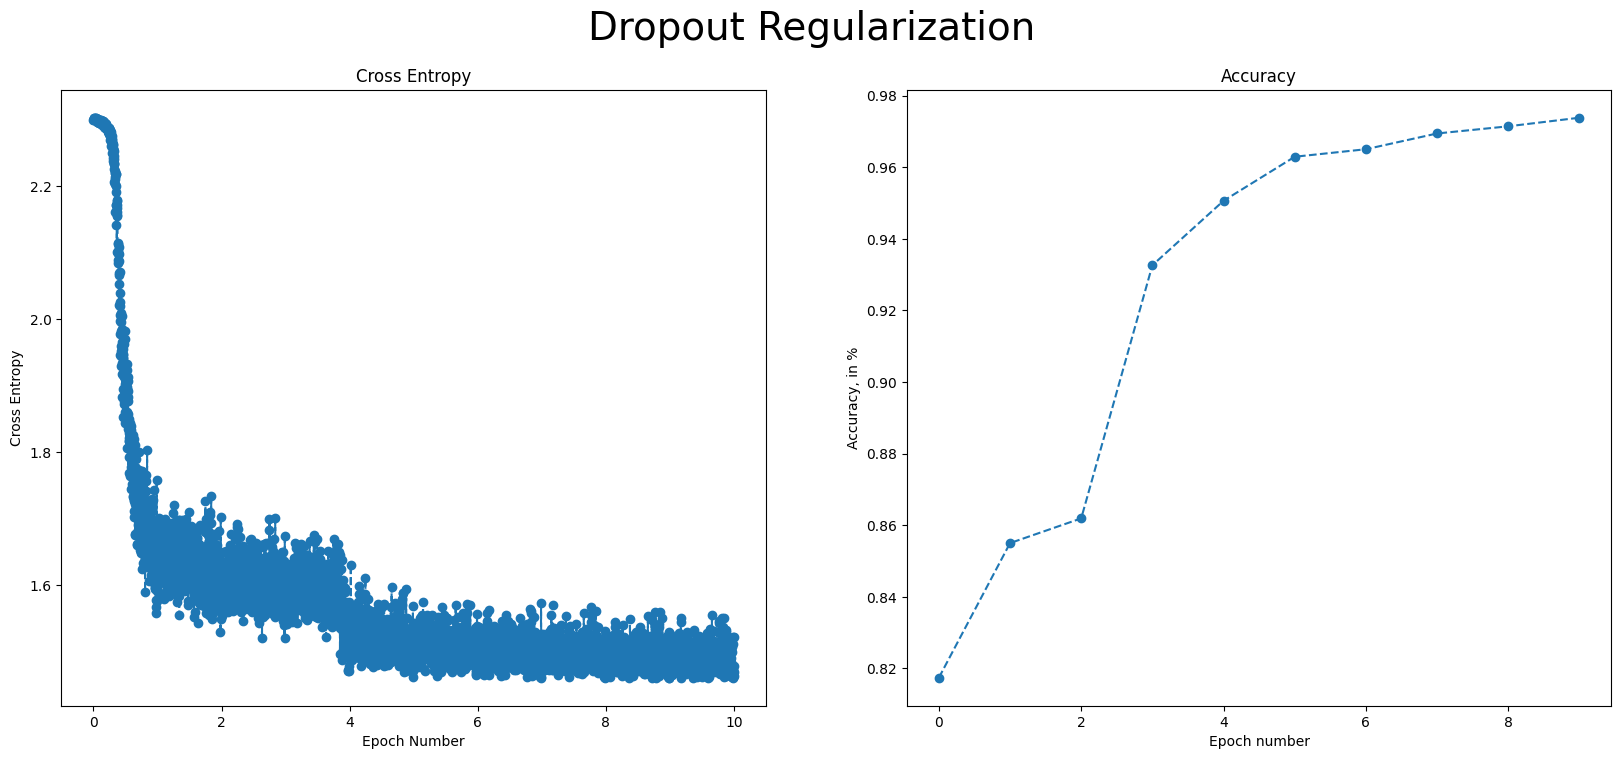

In [9]:
plot_results(epochs, losses, accuracies, title="Dropout Regularization")

## Confidence Penalty Regularization

In [13]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 3
losses, reg_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, conf_penalty=True, conf_penalty_lmbd=0.02
)

Epoch: 0
Accuracy of the network on the test images: 66 %
Epoch: 1
Accuracy of the network on the test images: 85 %
Epoch: 2
Accuracy of the network on the test images: 87 %


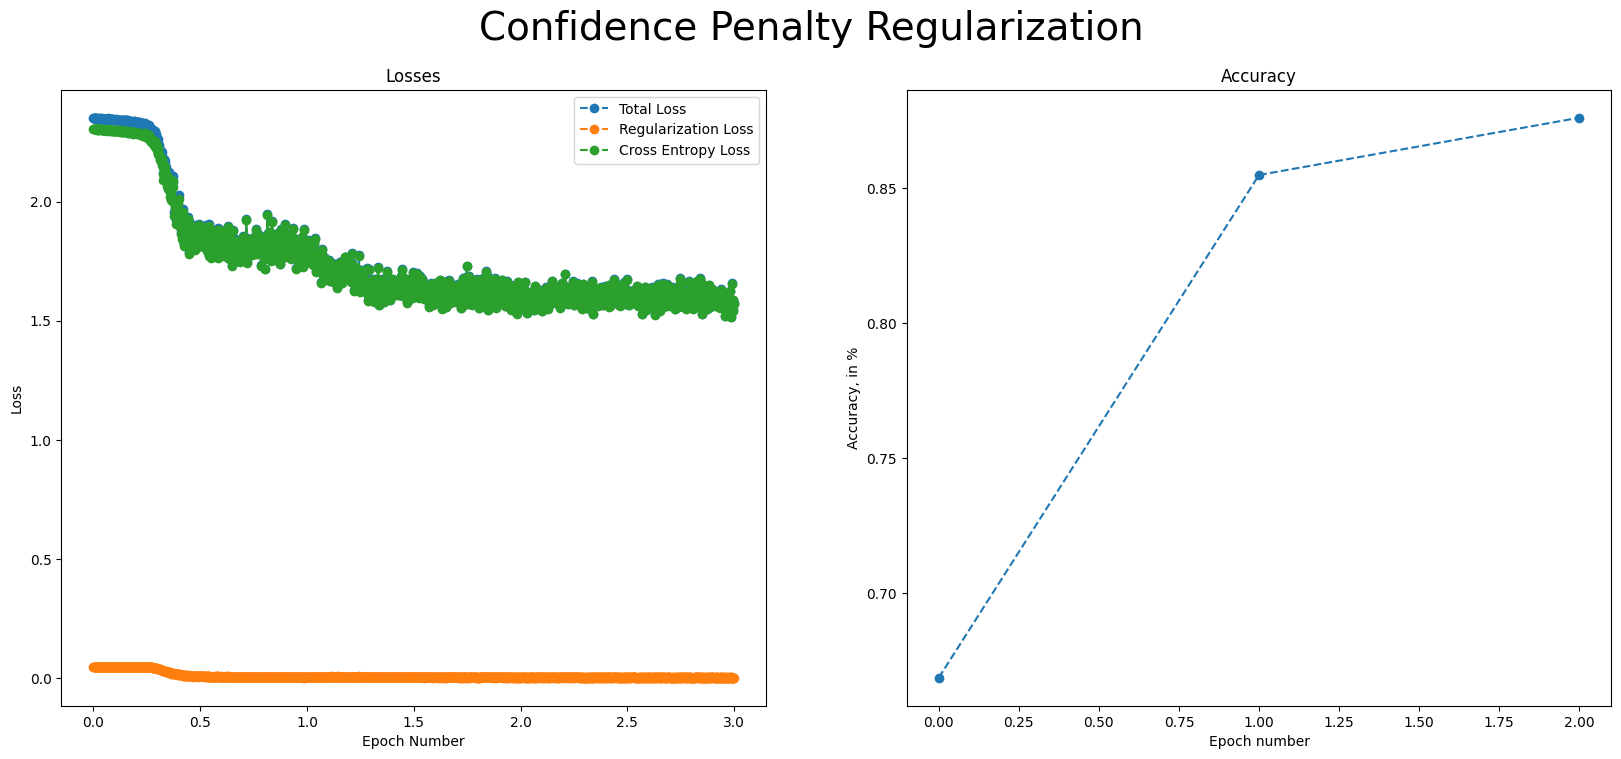

In [14]:
plot_reg_results(
    epochs, losses, reg_losses, accuracies, title="Confidence Penalty Regularization"
)

## Label Smoothing Regularization

In [8]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 3
losses, reg_losses, epochs, weights, accuracies = train(
    train_loader, model, n_epochs, label_smoothing=True, label_smoothing_lmbd=0.0000001
)

Epoch: 0
Accuracy of the network on the test images: 17 %
Epoch: 1
Accuracy of the network on the test images: 15 %
Epoch: 2
Accuracy of the network on the test images: 13 %


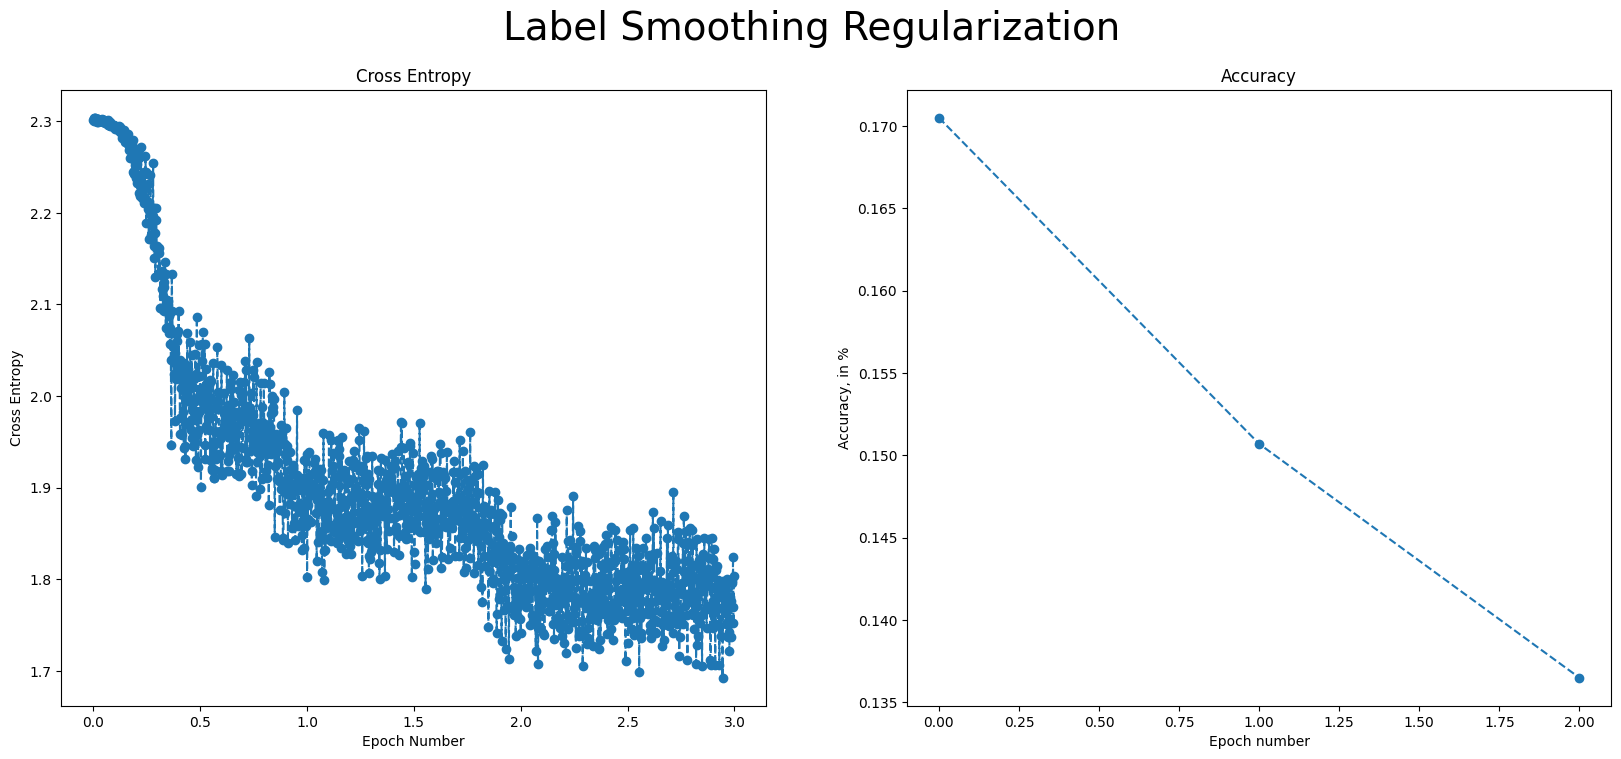

In [9]:
plot_results(epochs, losses, accuracies, title="Label Smoothing Regularization")